In [1]:
import numpy as np

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes',  labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import os
import math
import random

In [2]:
INPUT_1_HU  = "input/107-HU.in"
INPUT_1_SEG = "input/107-seg.in"

INPUT_2_HU  = "input2/89-HU.in"
INPUT_2_SEG = "input2/89-seg.in"

INPUT_3_HU  = "input3/121-HU.in"
INPUT_3_SEG = "input3/121-seg.in"

INPUT_4_HU  = "input4/187-HU.in"
INPUT_4_SEG = "input4/187-seg.in"

In [3]:
def file_to_matrix(path):
    with open(path, 'r') as f:
        mat = [[int(num) for num in line.split(' ')] for line in f]
    return np.array(mat)

def translate_ranges(img, from_range_low, from_range_high, to_range_low, to_range_high):
    return np.interp(img,
                    (from_range_low, from_range_high),
                    (to_range_low, to_range_high))

def save_fig(fig_id, fig_extension="png", resolution=300):
    path = os.path.join("images_research", fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [4]:
hu_mat = file_to_matrix(INPUT_3_HU)

In [5]:
hu_mat.shape

(512, 512)

In [6]:
print(hu_mat.min(), hu_mat.max())

-3024 1505


Saving figure hu_mat


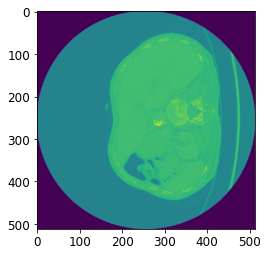

In [7]:
plt.imshow(hu_mat)
save_fig("hu_mat")

In [8]:
# 1. Hounsfield Thresholding + Normalization [0, 1]

In [9]:
def slice_window(img, level, window):
    low  = level - window / 2
    high = level + window / 2
    return img.clip(low, high)

In [10]:
hu_mat_slice = slice_window(hu_mat, 150, 50)

Saving figure hu_mat_slice


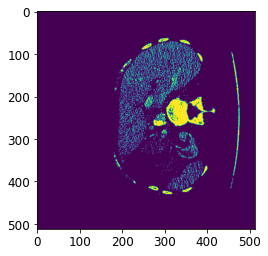

In [11]:
plt.imshow(hu_mat_slice)
save_fig("hu_mat_slice")

In [12]:
hu_mat_norm = translate_ranges(hu_mat_slice, hu_mat_slice.min(), hu_mat_slice.max(), 0, 1)

In [13]:
hu_mat_norm.shape

(512, 512)

In [14]:
np.unique(hu_mat_norm)

array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
       0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
       0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
       0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
       0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ])

Saving figure hu_mat_norm


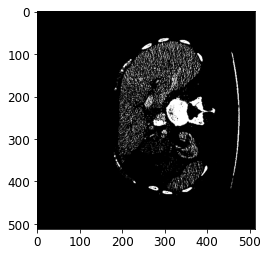

In [15]:
plt.imshow(hu_mat_norm, cmap='gray')
save_fig("hu_mat_norm")

In [16]:
from skimage.restoration import denoise_tv_chambolle, estimate_sigma

# sigma_est = estimate_sigma(hu_mat_norm, average_sigmas=True)
# print(f'Estimated Gaussian noise standard deviation = {sigma_est}')

hu_mat_norm_noise = denoise_tv_chambolle(hu_mat_norm, weight=0.1)

Saving figure hu_mat_norm_noise


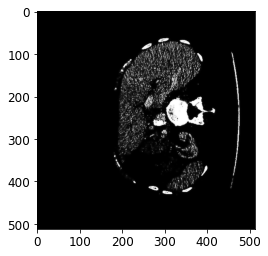

In [17]:
plt.imshow(hu_mat_norm_noise, cmap='gray')
save_fig("hu_mat_norm_noise")

In [18]:
# 2. Convex Hull (ROI)

In [19]:
from scipy.spatial import ConvexHull, convex_hull_plot_2d

In [20]:
hu_seg = file_to_matrix(INPUT_3_SEG)

In [21]:
hu_seg.shape

(512, 512)

In [22]:
points = []
for i in range(len(hu_seg)):
    for j in range(len(hu_seg[0])):
        if hu_seg[i][j] == 1:
            points.append([i, j])
points = np.array(points)

In [23]:
points.shape

(26207, 2)

In [24]:
points[0]

array([ 73, 308])

In [25]:
hull = ConvexHull(points)

In [26]:
hull.volume

30952.999999999993

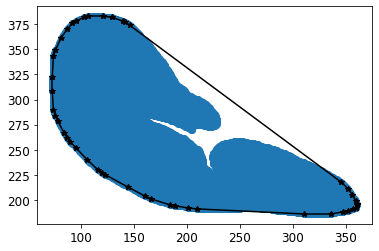

In [27]:
plt.plot(points[:,0], points[:,1], 'o')
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'k-*')

In [28]:
from matplotlib.path import Path

In [29]:
def in_hull(hull, points, x, radius=25):
    hull_path = Path(points[hull.vertices])
    # radius=x: "expands" the polygon; this ensures me the liver will not end up cutted
    return hull_path.contains_point(x, radius=radius)

In [30]:
hu_mat_hull = np.zeros((len(hu_mat_norm), len(hu_mat_norm[0])))

for i in range(len(hu_mat_norm)):
    for j in range(len(hu_mat_norm[0])):
        if not in_hull(hull, points, (i, j)):
            hu_mat_hull[i][j] = 0
        else:
            hu_mat_hull[i][j] = hu_mat_norm[i][j]

Saving figure hu_mat_hull


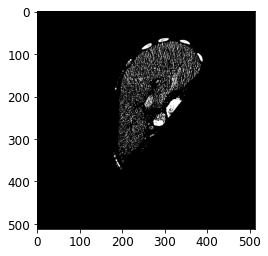

In [31]:
plt.imshow(hu_mat_hull, cmap='gray')
save_fig("hu_mat_hull")

In [32]:
# 3. Gamma Correction

In [33]:
from skimage import exposure
gamma_corrected = exposure.adjust_gamma(hu_mat_hull, 1)

Saving figure gamma_corrected


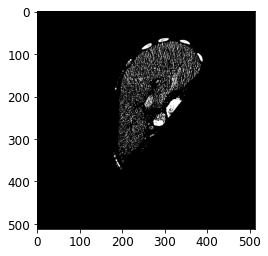

In [34]:
plt.imshow(gamma_corrected, cmap='gray')
save_fig("gamma_corrected")

In [35]:
# 4. Binarizing

In [36]:
threshold_confidence = 0.5
hu_mat_binary = np.array([[0 if el < threshold_confidence else 1 for el in row] for row in gamma_corrected])

In [37]:
hu_mat_binary.shape

(512, 512)

Saving figure hu_mat_binary


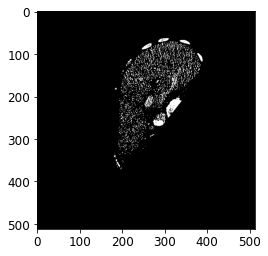

In [38]:
plt.imshow(hu_mat_binary, cmap='gray')
save_fig("hu_mat_binary")

In [39]:
from skimage.measure import label

In [40]:
all_labels = label(hu_mat_binary, background=0, connectivity=2)

Saving figure all_labels


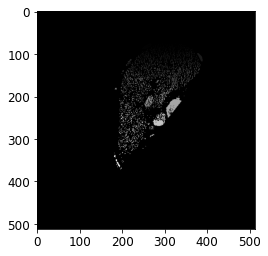

In [41]:
plt.imshow(all_labels, cmap='gray')
save_fig("all_labels")

In [42]:
# Morphology techniques

In [43]:
from skimage import morphology

In [44]:
hu_mat_bool = np.array(hu_mat_binary, bool)

In [45]:
rem_small = morphology.remove_small_objects(hu_mat_bool, min_size=20).astype(int)

Saving figure rem_small


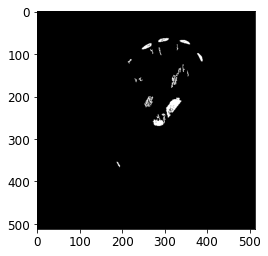

In [46]:
plt.imshow(rem_small, cmap='gray')
save_fig("rem_small")

In [47]:
mask = ~rem_small

Saving figure mask


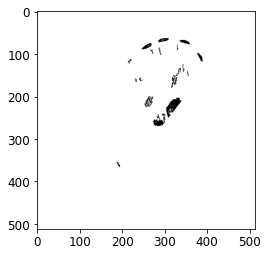

In [48]:
plt.imshow(mask, cmap='gray')
save_fig("mask")

In [49]:
hu_mat_masked = hu_mat_binary & mask

Saving figure hu_mat_masked


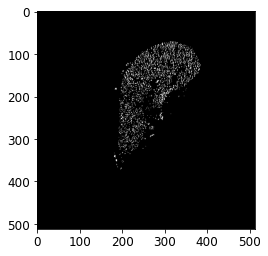

In [50]:
plt.imshow(hu_mat_masked, cmap='gray')
save_fig("hu_mat_masked")

In [51]:
from skimage.morphology import binary_dilation, binary_erosion

In [52]:
hu_mat_dilated = binary_dilation(hu_mat_masked)

Saving figure hu_mat_dilated


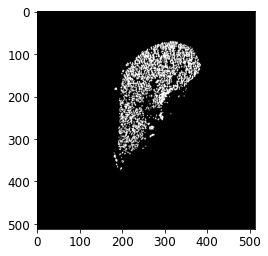

In [53]:
plt.imshow(hu_mat_dilated, cmap='gray')
save_fig("hu_mat_dilated")

Saving figure hu_seg


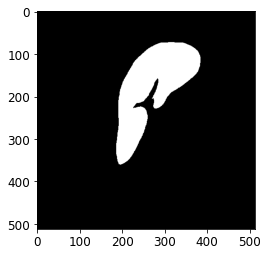

In [54]:
plt.imshow(hu_seg, cmap='gray')
save_fig("hu_seg")

In [55]:
from skimage import measure
contour_seg = measure.find_contours(hu_seg, 0.95)[0]

In [56]:
hull = ConvexHull(contour_seg)

In [57]:
hu_mat_dilated_masked_seg = np.zeros((len(hu_mat_dilated), len(hu_mat_dilated[0])))

for i in range(len(hu_mat_dilated)):
    for j in range(len(hu_mat_dilated[0])):
        if not in_hull(hull, contour_seg, (i, j), 15):
            hu_mat_dilated_masked_seg[i][j] = 0
        else:
            hu_mat_dilated_masked_seg[i][j] = hu_mat_dilated[i][j]

Saving figure hu_mat_dilated_masked_seg


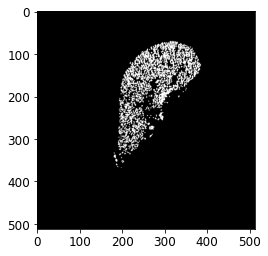

In [58]:
plt.imshow(hu_mat_dilated_masked_seg, cmap='gray')
save_fig("hu_mat_dilated_masked_seg")

In [59]:
img = hu_mat_dilated_masked_seg

In [60]:
from skimage.morphology import diameter_opening

diam_opened = diameter_opening(img, diameter_threshold=4, connectivity=2)

Saving figure diam_opened


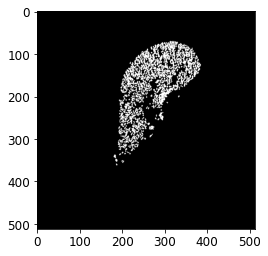

In [61]:
plt.imshow(diam_opened, cmap='gray')
save_fig("diam_opened")

In [62]:
img = diam_opened

Saving figure closed


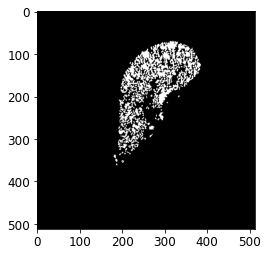

In [63]:
from skimage.morphology import area_closing

closed = area_closing(img, area_threshold=10)

plt.imshow(closed, cmap='gray')
save_fig("closed")

Saving figure opened


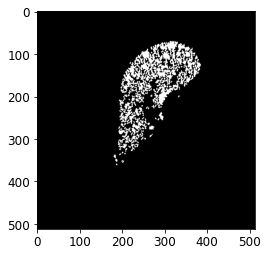

In [64]:
from skimage.morphology import area_opening

opened = area_opening(closed, area_threshold=10)

plt.imshow(opened, cmap='gray')
save_fig("opened")

In [65]:
from skimage.morphology import remove_small_objects

In [66]:
noise_red = remove_small_objects(opened.astype(bool), 10)

Saving figure noise_red


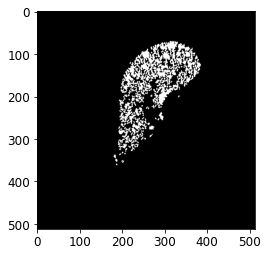

In [67]:
plt.imshow(noise_red, cmap='gray')
save_fig("noise_red")

In [68]:
img_to_sobel = noise_red
# img_to_sobel = hu_mat_dilated_masked_seg

In [69]:
from skimage.filters import sobel
edges = sobel(img_to_sobel)

Saving figure edges


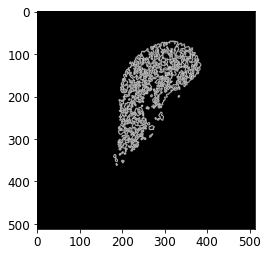

In [70]:
plt.imshow(edges, cmap='gray')
save_fig("edges")

In [71]:
rem_small_edges = morphology.remove_small_objects(edges.astype(bool), min_size=20).astype(int)

Saving figure rem_small_edges


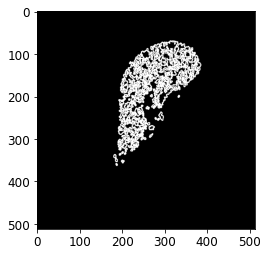

In [72]:
plt.imshow(rem_small_edges, cmap='gray')
save_fig("rem_small_edges")

In [73]:
rem_small_edges_dilated = binary_dilation(binary_dilation(binary_dilation(rem_small_edges)))

Saving figure rem_small_edges_dilated


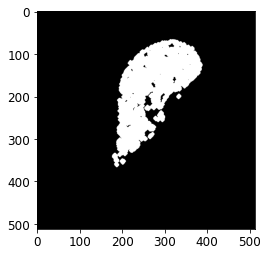

In [74]:
plt.imshow(rem_small_edges_dilated, cmap='gray')
save_fig("rem_small_edges_dilated")

Saving figure fill


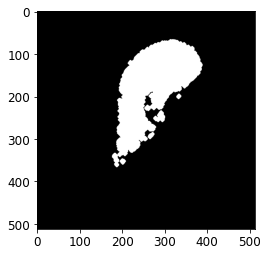

In [75]:
from scipy.ndimage import binary_fill_holes

fill = binary_fill_holes(rem_small_edges_dilated)

plt.imshow(fill, cmap='gray')
save_fig("fill")

In [76]:
# Final step `active_contour`, starting from the `hu_seg` points

In [77]:
contour_seg = measure.find_contours(hu_seg, 0.95)[0]

In [78]:
from skimage.filters import gaussian
from skimage.segmentation import active_contour

snake = active_contour(gaussian(fill, 3, preserve_range=False),
                       contour_seg, alpha=0.001, beta=200, gamma=0.01, w_edge=3)

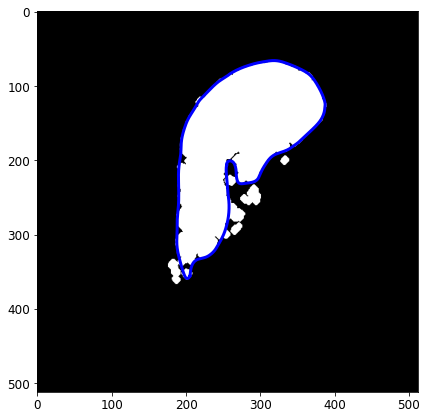

In [79]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(fill, cmap=plt.cm.gray) # plot base image
# ax.plot(contour_seg[:, 1], contour_seg[:, 0], '--r', lw=3)
ax.plot(snake[:, 1], snake[:, 0], '-b', lw=3)

In [80]:
# Mask the liver with the snake

In [81]:
snake_path = Path(snake)
liver_mask = np.zeros((len(hu_mat), len(hu_mat[0])))

for i in range(len(liver_mask)):
    for j in range(len(liver_mask[0])):
        if snake_path.contains_point((i, j)):
            liver_mask[i][j] = 1
        else:
            liver_mask[i][j] = 0

Saving figure liver_mask


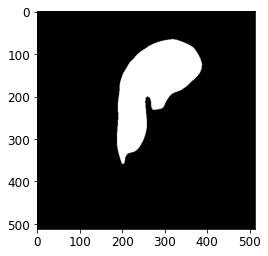

In [82]:
plt.imshow(liver_mask, cmap='gray')
save_fig("liver_mask")